# Teleseismic *P*-wave coda autocorrelation

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tsonpham/ObsSeis-VNU/blob/master/Day4/D4_Lab.ipynb)

Thanh-Son Pham (ThanhSon.Pham@anu.edu.au)

- October 2017: First release on [GitHub](https://github.com/tsonpham/PCodaAutocorrelation.git).
- March 2025: Revision for Observational Seismology Workshop at VNU Hanoi University of Science.

This notebook implements a lightweight version of the *P wave coda autocorrelation* method in the Python programing language. The method is demonstrated with seismic data acquired by station [YT ST01](https://ds.iris.edu/mda/YT/ST01/?starttime=2010-01-27T00:00:00&endtime=2012-12-31T23:59:59) operating from 2010 to 2012 over the ~3 km thick icesheet in West Antarctica.

For more details, we refer to the following articles:
- Phạm T.-S. and H. Tkalčić, *On the feasibility and use of teleseismic P-wave coda autocorrelation for mapping shallow seismic discontinuities*, J. Geophys. Res.: Solid Earth, 122, doi:10.1002/2017JB013975, **2017**.
- Phạm T.-S. and H. Tkalčić, *Antarctic ice properties revealed from teleseismic P wave coda autocorrelation*, J. Geophys. Res.: Solid Earth, 123, doi:10.1029/2018JB016115, **2018**.

### Overview

In this method, we autocorrelate seismic records containing the P-wave arrival and its intermediate coda to reveal reflection signals from subsurface discontinuity. As described below, we first use `spectral normalization` to adjust the frequency content of individual P-wave coda record. The autocorrelation is then calculated in the frequency domain by squaring the modified power spectrum. Autocorrelograms corresponding to multiple earthquakes are then summed up (i.e., stacked) to improve the signal to noise ratio.

<!-- ![](https://agupubs.onlinelibrary.wiley.com/cms/asset/5fab2346-82da-41a5-a4b9-68965dee2cea/jgrb52088-fig-0004-m.jpg) -->

In [1]:
!pip install obspy basemap

### Spectral normalization
We use an adaptive weighting function to normalize the complex spectrum of the input waveform before computing the autocorrelation function. The spectral whitening is defined in a similar way to the running-absolute-mean normalization [Bensen et al., 2007] in the time domain as

\begin{equation}
\hat{s}_n = \frac{s_n} {\frac{1}{2N + 1} \sum_{j=n-N}^{n+N} |s_j|}.
\end{equation}

The number of averaging points $N$ in the denominator is alternatively refered as spectral whitening width $\Delta W = 2 N \Delta \omega$, where $\Delta \omega$ is the discrete frequency step $\Delta \omega = 1/L$ and $L$ is the length of the input time trace. Tuning the whitening width $\Delta W$ may change the performance of the method. We recommend to do experiments with this parameter to find an optimal value for your application.

In [2]:
import numpy as np
from scipy.signal import fftconvolve, hilbert

def smooth_avg(arr, winlen):
    """
    Smoothing a time series by averaging its values in a moving window. This averaging
    window operation can be done efficiently with an convolution in the frequency domain.
    """

    window = np.ones(winlen) / (1.0 * winlen)
    return fftconvolve(arr, window, 'same')

def spectral_whitening(arr, delta, freq_width, npts=None, returnweight=False):
    """
    Frequency whitening of a time series by balancing its spectrum by smoothed absolute
    array of the spectrum.

    arr        : input seismogram
    delta      : sampling time step of the input
    freq_width : spectral whitening width
    returnweith: return the averaging width or not
    """
    npts = len(arr) if npts is None else npts
    carr = np.fft.fftshift(np.fft.fft(arr, 2 * npts))

    Nyfreq = 0.5 / delta
    spec_step = Nyfreq / npts
    if freq_width != None:
        winlen = int(0.5 * freq_width / spec_step) * 2 + 1
        weight = smooth_avg(np.abs(carr), winlen)
        if any(weight < 1e-8): raise Exception('Zero division')

        carr /= weight
        carr[weight<1e-6*np.max(weight)] = 0

    if returnweight:
        return carr[npts-1:2*npts], weight[npts-1:2*npts]
    else:
        return carr[npts-1:2*npts]

### Autocorrelation
The autocorrelation of a time trace is the inverse transform of the whitend power spectrum.
$$
a_n(\omega) = |\hat{s}_n|^2
$$
The discrete spectrum of the autocorrelation in the frequemcy domain, $a_n(\omega)$ is inverse Fourier transformed to the time domain.

The only causal part of the autocorrelation trace is retained. We use a cosine taper to the central peak and bandpass in the frequency band 1-5 Hz.

In [3]:
def compute_auto(tr, freq_width, npts=None):
    """
    Computing the autocorrelation function of the whitened trace.

    tr: input data seismogram
    freq_width: spectral whitening width
    """
    npts = tr.stats.npts if npts is None else npts
    ## whitening and autocorrelating
    spectrum = spectral_whitening(tr.data, tr.stats.delta, freq_width, npts)
    ## autocorrelating
    tr.data = np.fft.irfft(np.abs(spectrum)**2)[0:npts]

    # post processing: tapering and filtering
    taper_width = 0.5 / (npts * tr.stats.delta)
    tr.taper(type='cosine', max_percentage=taper_width)
    tr.filter('bandpass', freqmin=1.0, freqmax=5.0, corners=4, zerophase=True)
    tr.taper(type='cosine', max_percentage=taper_width)

    return tr

### Phase weighted stacking

*Phase-weighted stacking* is a nonlinear stacking technique to sufficiently enhance coherent signals and suppress noise [Schimmel and Paulssen, 1997]. It uses the averaging phase of the input traces to weight the linear stack of the input.

The analytical signals of a one-sided autocorrelogram $s_n$ is given by
$$
S_n(t) = s_n(t) + i H_n(t) = A_n(t) e^{i\Phi_n(t)}
$$
where $H_n(t)$ is the Hilbert transform of the original trace $s_n(t)$. And, $A_n(t)$, $\Phi_n(t)$ are the amplitude and phase components of the analytic signal. The phase-weighted stack of $N$ input traces is defined as
$$
g(t) = \frac{1}{N} \sum_{n=1}^N s_n(t) \; \left|\frac{1}{N}\sum_{n=1}^N e^{i\Phi_n(t)}\right|^\eta.
$$
The order $\eta$ is used to adjust the importance of the phase weighting factor. When $\eta = 0$, the 0th order phase-weighted stack becomes a linear stack.

In [4]:
from obspy.core import Trace

def data_stack(stream, order):
    """
    Phase weighted stacking

    stream: input stream of one-sided autocorrelograms
    order : order of the weight phase
    """
    stack = 0
    phase = 0j

    if order == 0:
        stack = np.sum([acorr.data for acorr in stream], axis=0)
        return Trace(header={'npts': len(stack), 'delta': stream[0].stats.delta}, data=stack)

    for acorr in stream:
        stack += acorr.data

        ## calculate phase
        asig = hilbert(acorr.data)
        phase += asig / np.abs(asig)

    stack /= len(stream)
    weight = np.abs(phase / len(stream))

    return Trace(header={'npts': len(stack), 'delta': stream[0].stats.delta}, data=stack * weight**order)

### Application for pilot station ST01 (West Antarctica)

This section contains step-by-step guide to acquire seismic data from remote server, perform processing, visualise data, and make initial interpretation of the results in the geological context.


#### Data preparation

First, we query the geographical station of station ST01 from IRIS Data Management center using an `obspy fdsn client`.

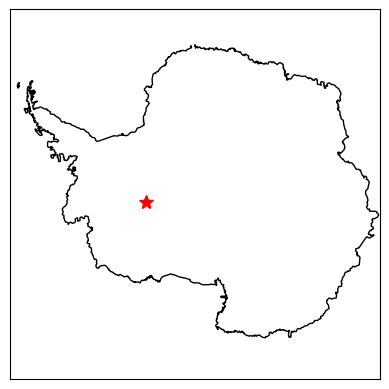

In [5]:
from obspy.clients.fdsn import Client
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

## definte the IRIS client
iris = Client('IRIS')

## define the network and station code of interest
netcode = 'YT'
stacode = 'ST01'

## get station information
inv = iris.get_stations(network=netcode, station=stacode, level='station')

## get the station coordinates
stla = inv[0][0].latitude
stlo = inv[0][0].longitude

## plot the station location on map for sanity check
m = Basemap(projection='spstere', boundinglat=-65, lon_0=180, resolution='l')
m.drawcoastlines()
m.plot(stlo, stla, 'r*', markersize=10, latlon=True)
plt.show()

Second, search for all catalogued earthquakes of magnitude 6.0+, between distances from 30 to 95$^\circ$ from the seismic station of interest.

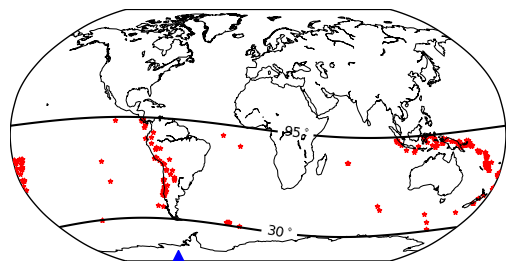

In [6]:
## get the event metadata from the IRIS server
cat = iris.get_events(starttime=inv[0][0].start_date, endtime=inv[0][0].end_date,
    latitude=stla, longitude=stlo, minradius=30.0, maxradius=95.0, minmagnitude=6.0)

## plot the event location on a global map
m = Basemap(projection='robin', lon_0=0, resolution='c')
m.drawcoastlines(linewidth=.75)
## plot event location by red stars
m.scatter([_.preferred_origin().longitude for _ in cat], [_.preferred_origin().latitude for _ in cat],
    latlon=True, s=10, c='r', marker='*')
## plot the station location by blue triangle
m.plot(stlo, stla, 'b^', markersize=10, latlon=True)

## plot the tissots showing the distance from the station
_lats = np.linspace(-90, 90, 100)
_lons = np.linspace(-180, 180, 100)
lons, lats = np.meshgrid(_lons, _lats)
from obspy.geodetics import locations2degrees
gcarc = locations2degrees(lats, lons, stla, stlo)
cs = m.contour(lons, lats, gcarc, levels=[30, 95], colors='k', latlon=True)
# labels the countour inline with some custom format
plt.clabel(cs, fmt='%2.0f$^\circ$', inline=True)

plt.show()

Third, waveform data corresponding to with seismic station codes and event catalog are requested. To do so, we need to first predict the travel time of *P* from sources to the receivers. Then request 60-second long data segments starting from 10 second before the predicted time.

In [7]:
from obspy.taup import TauPyModel
from obspy.geodetics import gps2dist_azimuth
from obspy.clients.fdsn.client import FDSNNoDataException
taup_model = TauPyModel(model='ak135')

bulk = []
for event in cat:
    origin = event.preferred_origin()
    ## calculate the P-wave arrival time from the event to the station
    p_arv = taup_model.get_travel_times_geo(origin.depth/1e3, origin.latitude,
                origin.longitude, stla, stlo, phase_list=['P'])[0]
    p_arv_time = origin.time + p_arv.time
    ## enclose the calculated information into list
    bulk.append((netcode, stacode, '', 'BHZ,HHZ', p_arv_time-10, p_arv_time+50))

## get the waveform data
dstream = iris.get_waveforms_bulk(bulk, threaded=True, minimumlength=55)

## resample the data to 40 Hz (if necessary) and remove the linear data trend
dstream.resample(40.0)
dstream.detrend('linear')

103 Trace(s) in Stream:

YT.ST01..BHZ | 2010-02-01T22:40:43.099998Z - 2010-02-01T22:41:43.074998Z | 40.0 Hz, 2400 samples
...
(101 other traces)
...
YT.ST01..BHZ | 2011-01-17T19:33:47.874998Z - 2011-01-17T19:34:47.849998Z | 40.0 Hz, 2400 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

#### Data processing and results

Autocorrelograms are computed for individual seismograms and then stacked to improve signal to noise ratio.

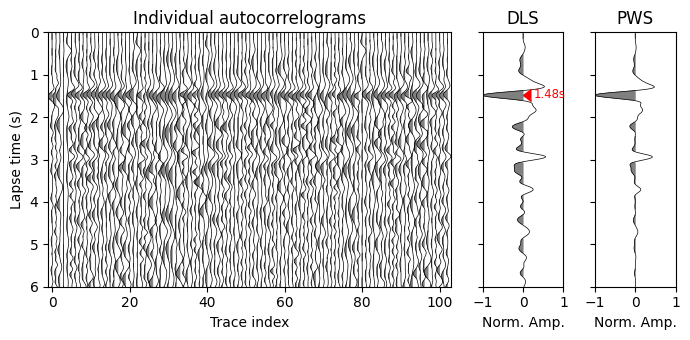

In [8]:
from obspy.core import Stream

## Compute autocorrelograms for all downlaoded data
auto_stream = Stream()
for tr in dstream.copy():
    auto = compute_auto(tr, freq_width=0.5, npts=60*40) # 60 seconds at 40 Hz
    auto_stream.append(auto)
## Data linear stack (DLS)
dls = data_stack(auto_stream, order=0)
## Phase weighted stack (PWS) of order 1
pws = data_stack(auto_stream, order=1)
## Time vector for plotting
tvec = np.arange(dls.stats.npts) * dls.stats.delta
## Pick the reflection time
t_2p = tvec[np.argmin(dls.data[tvec<6])]

## Create a figure for plotting
fig, ax = plt.subplots(1, 3, figsize=(7, 3.5), sharey=True, width_ratios=[1, 0.2, 0.2])
## Plot individual autocorrelograms
for i, auto in enumerate(auto_stream):
    # normalize the individual autocorrelogram by its maximum value
    data = auto.data / np.max(np.abs(auto.data))
    # plot the waveform using its trace index in the stream as the x-axis
    ax[0].plot(data + i, tvec, lw=0.5, color='black')
    # fill the negative part of the waveform with gray color
    ax[0].fill_betweenx(tvec, i, data + i, lw=0.5, color='gray', where=(data < 0))
ax[0].set(ylim=(6, 0), ylabel='Lapse time (s)', xlabel='Trace index', title='Individual autocorrelograms')
ax[0].set(xlim=(-1, len(auto_stream)))
## Plot the DLS
dls.data /= np.max(np.abs(dls.data))
ax[1].plot(dls.data, tvec, lw=0.5, color='black')
ax[1].plot(0, t_2p, marker=4, c='r', ms=8)
ax[1].text(0.25, t_2p, '%.2fs'%t_2p, color='r', va='center', fontsize='small')
ax[1].fill_betweenx(tvec, 0, dls.data, lw=0.5, color='gray', where=(dls.data < 0))
ax[1].set(xlim=(-1, 1), xlabel='Norm. Amp.', title='DLS')
## Plot the PWS
pws.data /= np.max(np.abs(pws.data))
ax[2].plot(pws.data, tvec, lw=0.5, color='black')
ax[2].fill_betweenx(tvec, 0, pws.data, lw=0.5, color='gray', where=(pws.data < 0))
ax[2].set(xlim=(-1, 1), xlabel='Norm. Amp.', title='PWS')

fig.tight_layout()
plt.show()

The delayed of the reflection peak of the ice-bedrock interface, $t_{2p}$, is about 1.5 seconds. If taking the average *P*-wave speed, $v_p$, in ice is about 3.9 km/s, the estimate ice thickness beneath station ST01 is.
$$
H \approx \dfrac{t_{2p}v_p}{2} = 2.9\; \text{km}.
$$

In the practical excercises, we will look at the autocorrelograms along a line of seismic stations and compare with ice thickness obtained from other method.